In [1]:
import os
import pandas as pd
from configparser import ConfigParser

cfg = ConfigParser()
cfg.read('../config.ini')
fetex_dir = cfg.get('dirs','fetex')
accidents_dir = cfg.get('dirs', 'accidentes')
metrics_dir = cfg.get('dirs', 'road_metrics')
grid_id = cfg.get('grid', 'default')
print(f'using {grid_id}')

using m250


## Limpieza de datos

In [2]:
def clean_up_columns(data):
    data.columns = map(str.lower, data.columns)
    data.columns = map(str.strip, data.columns)
    if 'geometry' in data.columns:
        data.drop('geometry', axis=1, inplace=True)
    if 'processed' in data.columns:
        data.drop('processed', axis=1, inplace=True)
    if 'sample' in data.columns:
        data.drop('sample', axis=1, inplace=True)
    data = data.dropna()
    data.set_index('id', inplace=True)
    return data

def join_dataframes(*multiple_df):
    output = []
    for df in multiple_df:
        if len(output):
            output = df.join(output)
        else:
            output = df
    return output.dropna()       


# Load Accidents
accidents = pd.read_csv(f'{accidents_dir}/{grid_id}_c.csv')
accidents = clean_up_columns(accidents) 

# Load Fetex
fetex = pd.read_csv(f'{fetex_dir}/r_fetex_{grid_id}.txt')
fetex = clean_up_columns(fetex)

# Load metrics data
metrics = pd.read_csv(f'{metrics_dir}/250.csv', delimiter=';')
metrics = clean_up_columns(metrics)

In [3]:
# Load train/test split
train = pd.read_csv(f'../support_data/{grid_id}/train.csv', index_col='id')
test = pd.read_csv(f'../support_data/{grid_id}/test.csv', index_col='id')

### Now Keras

In [4]:
import numpy as np
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/home/drueda/virtualenvs/dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
"""
Setup training parameters
"""
batch_size = 2
num_classes = 4
num_epoch = 30

In [6]:
def train_dataset(train, test, name):
        x_train, y_train = train.drop('label', axis=1), train.label
        x_test, y_test = test.drop('label', axis=1), test.label
        y_train = to_categorical(y_train)
        y_test = to_categorical(y_test)
        _, features = x_train.shape

        np.random.seed(7)
        _, features = x_train.shape
        aux_input = Input(shape=(features,) )
        aux = Dense(4096, activation='sigmoid')(aux_input)
        aux = Dense(4096, activation='sigmoid')(aux)
        aux = Dense(4, activation='sigmoid')(aux)
        predictions = Activation('softmax')(aux)

        model = Model(inputs=aux_input, outputs=predictions)
        lrate=0.001
        sgd = SGD(lr=lrate)
        model.compile(optimizer=sgd,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        top_weights_path = f'{name}_net_lr_{lrate}'

        callback_list = [TensorBoard(log_dir=f'logs/{top_weights_path}'), 
                         #EarlyStopping(monitor='val_loss', patience=10, verbose=0),
                         ModelCheckpoint(f'models/{top_weights_path}', verbose=0, save_best_only=True, monitor='val_loss')]

        model.fit(x_train, 
                  y_train, 
                  validation_data=(x_test, y_test), 
                  epochs=20, 
                  shuffle=True,
                  batch_size=4,
                  callbacks=callback_list, verbose=0)

        model.load_weights(f'models/{top_weights_path}')

        y_pred = model.predict(x_test)
        y_pred = np.argmax(y_pred, axis=-1)
        y_test = np.argmax(y_test, axis=-1)
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='g')
        
        plt.title(f'{name} lr:{lrate}')
        plt.show()


In [7]:
acc_train = join_dataframes(train, accidents)
acc_test = join_dataframes(test, accidents)

fx_train = join_dataframes(train, fetex)
fx_test = join_dataframes(test, fetex)

metrics_train = join_dataframes(train, metrics)
metrics_test = join_dataframes(test, metrics)

acc_fx_train = join_dataframes(train, accidents, fetex)
acc_fx_test = join_dataframes(test, accidents, fetex)

fx_metrics_train = join_dataframes(train, fetex, metrics)
fx_metrics_test = join_dataframes(test, fetex, metrics)

acc_metrics_train = join_dataframes(train, accidents, metrics)
acc_metrics_test = join_dataframes(test, accidents, metrics)

acc_fx_metrics_train = join_dataframes(train, accidents, fetex, metrics)
acc_fx_metrics_test = join_dataframes(test, accidents, fetex, metrics)

In [8]:
single_data = {'accidents':(acc_train, acc_test), 'fetex':(fx_train, fx_test), 'metrics':(metrics_train, metrics_test)}
double_data = {'accidents_fetex':(acc_fx_train, acc_fx_test), 'fetex_metrics':(fx_metrics_train, fx_metrics_test), 'accidents_metrics':(acc_metrics_train, acc_metrics_test)}
triple_data = {'acc_fx_metrics':(acc_fx_metrics_train, acc_fx_metrics_test)}

Instructions for updating:
Use the retry module or similar alternatives.


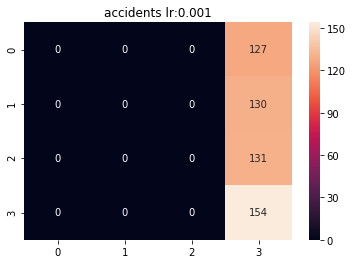

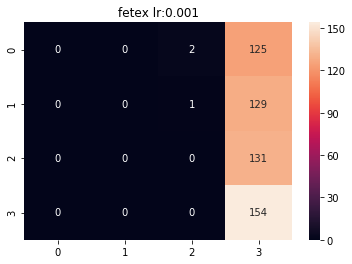

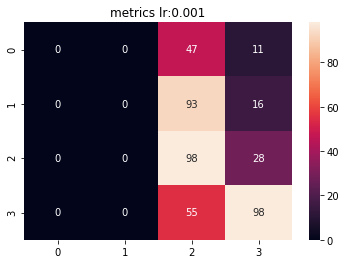

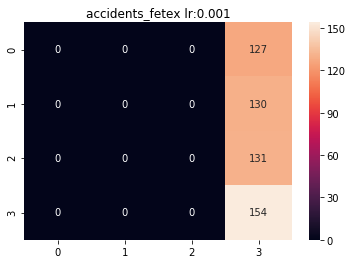

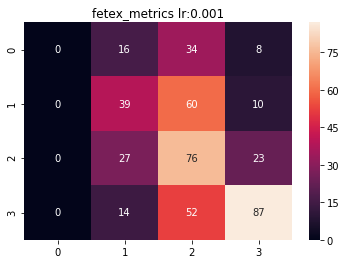

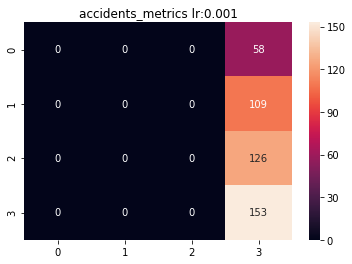

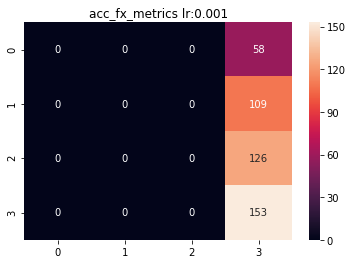

In [9]:
for data_list in [single_data, double_data, triple_data]:
    for key, (train, test) in data_list.items():
        train_dataset(train, test, key)